In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
def load_scw_events():

        #Load the Brown and Dowdy (2021, JSHESS) measured SCW events at Melbourne, Sydney, Brisbane (Oakey+Amberley) and Woomera

        df_auto = pd.DataFrame()
        cols = ["gust_time_utc","lat","lon","stn_name","wind_gust"]
        events = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/obs/aws/convective_wind_gust_aus_2005_2018.pkl")
        for loc in ["Melbourne","Sydney","Amberley","Oakey","Woomera"]:
            cond = (events["wind_gust"] >= 25) & (events["stn_name"]==loc) & (events["lightning"]>=2)
            loc_events = events[cond][cols]
            df_auto = pd.concat([df_auto,loc_events.set_index("gust_time_utc")], axis=0)

        df_auto.loc[df_auto["stn_name"]=="Melbourne","rid"] = "2"
        df_auto.loc[df_auto["stn_name"]=="Sydney","rid"] = "71"
        df_auto.loc[df_auto["stn_name"]=="Amberley","rid"] = "66"
        df_auto.loc[df_auto["stn_name"]=="Oakey","rid"] = "50"
        df_auto.loc[df_auto["stn_name"]=="Woomera","rid"] = "27"

        df_auto.loc[df_auto["stn_name"]=="Melbourne","stn_id"] = "086282"
        df_auto.loc[df_auto["stn_name"]=="Sydney","stn_id"] = "066037"
        df_auto.loc[df_auto["stn_name"]=="Amberley","stn_id"] = "040004"
        df_auto.loc[df_auto["stn_name"]=="Oakey","stn_id"] = "041359"
        df_auto.loc[df_auto["stn_name"]=="Woomera","stn_id"] = "016001"

        df_auto.loc[df_auto["stn_name"]=="Melbourne","state"] = "vic"
        df_auto.loc[df_auto["stn_name"]=="Sydney","state"] = "nsw"
        df_auto.loc[df_auto["stn_name"]=="Amberley","state"] = "qld"
        df_auto.loc[df_auto["stn_name"]=="Oakey","state"] = "qld"
        df_auto.loc[df_auto["stn_name"]=="Woomera","state"] = "sa"

        return df_auto

In [3]:
#Load Brown and Dowdy (2021) cases
pot_cases = load_scw_events()

#Load radar info for all cases at Melb, Syd, Bris, Woom. This is generated by case_driver.py
pot_case_storm_stats = pd.read_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/potential_cases.csv")
pot_case_storm_stats = pot_case_storm_stats.set_index(pd.DatetimeIndex(pot_case_storm_stats["gust_time_utc"]))
pot_cases = pd.merge(pot_cases, pot_case_storm_stats[["uid","scan","in10km"]], left_index=True, right_index=True)

#Flag cases from Brown and Dowdy (2021) that don't have a nearby storm object (case=3), or that don't have data (case=4)
pot_cases.loc[(pot_cases.in10km==0), "case"] = 3
pot_cases.loc[(pot_cases.in10km.isna()), "case"] = 4

#For Melb, Syd, Woom, Amberley, go through and flag the top 9 events from Brown and Dowdy (2021) as cases for analysis (case=1)
#For ties, select the case that appears earliest in the record (default behaviour for dataframe indexed by time)
no_of_events = 9
for loc in ["Melbourne","Sydney","Woomera","Amberley"]:
    temp = pot_cases[pot_cases.stn_name==loc].sort_values("wind_gust",ascending=False)
    cnt=1
    for i in np.arange(temp.shape[0]):
        if (np.isnan(temp.iloc[i].case)) & (cnt<=no_of_events):
            pot_cases.loc[temp.index[i],"case"] = 1
            cnt=cnt+1
        elif (np.isnan(temp.iloc[i].case)):
            pot_cases.loc[temp.index[i],"case"] = 0
        else:
            pass
        
#For Amberley, there's only 4 events, so get the rest from Oakey.
no_of_events = 9 - (pot_cases[pot_cases.stn_name=="Amberley"].case.sum())
loc = "Oakey"
temp = pot_cases[pot_cases.stn_name==loc].sort_values("wind_gust",ascending=False)
cnt=1
for i in np.arange(temp.shape[0]):
    if (np.isnan(temp.iloc[i].case)) & (cnt<=no_of_events):
        pot_cases.loc[temp.index[i],"case"] = 1
        cnt=cnt+1
    elif (np.isnan(temp.iloc[i].case)):
        pot_cases.loc[temp.index[i],"case"] = 0
    else:
        pass
    
pot_cases.query("case==1").to_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/case_study_list.csv")    

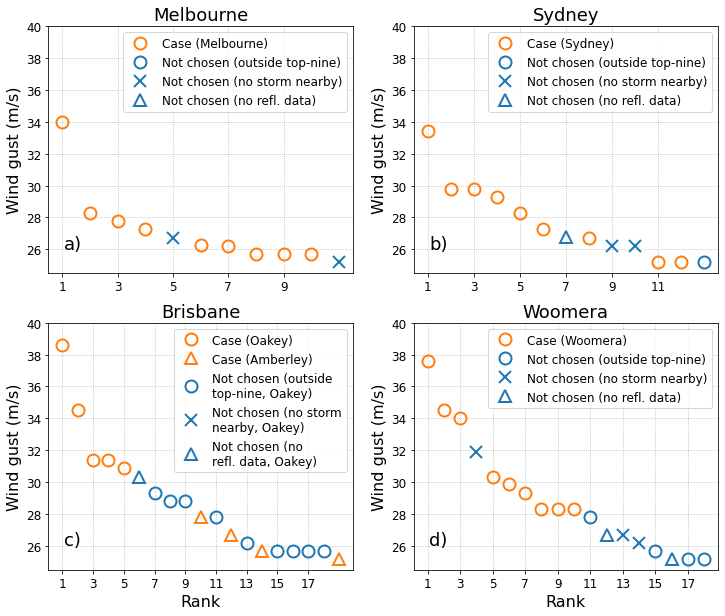

In [4]:
#Do some plotting. For the purposes of marker styles, flag Amberley events with case=2.

pot_cases.loc[(pot_cases.case==1) & (pot_cases.stn_name=="Amberley"),"case"] = 2

plt.figure(figsize=[12,10])
cnt=0

markers={0:"o",1:"o",2:"^",3:"x",4:"^"}
palette={0:"tab:blue",1:"tab:orange",2:"tab:orange",3:"tab:blue",4:"tab:blue"}
facecolors={0:"none",1:"none",2:"none",3:"tab:blue",4:"none"}
s=12

titles = ["Melbourne","Sydney","Brisbane","Woomera"]
letter = ["a","b","c","d"]
for location in [["Melbourne"],["Sydney"],["Oakey","Amberley"],["Woomera"]]:
    
    ax=plt.subplot(2,2,cnt+1)
    temp = pot_cases[np.in1d(pot_cases.stn_name,location)].sort_values(["wind_gust","case"])
    temp["order"] = np.arange(temp.shape[0],0,-1)

    for c in temp.case.unique():
        ax.plot(temp[temp.case==c].order, temp.wind_gust[temp.case==c], marker=markers[c], color=palette[c],
                  mfc=facecolors[c], mew=2, ms=s, linestyle="none")

    ax.grid(linestyle=":")
    ax.set_ylim([24.5,40])
    ax.set_xticks(np.arange(1,temp.shape[0],2))
    if cnt in [2,3]:
        ax.set_xlabel("Rank", size=16)
    ax.set_ylabel("Wind gust (m/s)", size=16)
    ax.tick_params("both",labelsize=12)
    ax.set_title(titles[cnt],size=18)
    ax.text(0.05,0.1,letter[cnt]+")",size=18,transform=ax.transAxes)
    
    if cnt in [0,1,3]:
        custom = [Line2D([], [], marker='o', color='tab:orange', linestyle='None', mfc="none", ms=s, mew=2),
                    Line2D([], [], marker='o', color='tab:blue', linestyle='None', mfc="none", ms=s, mew=2),
                    Line2D([], [], marker='x', color='tab:blue', linestyle='None', mfc="tab:blue", ms=s, mew=2),
                     Line2D([], [], marker='^', color='tab:blue', linestyle='None', mfc="none", ms=s, mew=2)]
        plt.legend(custom, ['Case ('+location[0]+")", 'Not chosen (outside top-nine)',
                           'Not chosen (no storm nearby)','Not chosen (no refl. data)'], loc='upper right', fontsize=12)
    else:
        custom = [Line2D([], [], marker='o', color='tab:orange', linestyle='None', mfc="none", ms=s, mew=2),
                    Line2D([], [], marker='^', color='tab:orange', linestyle='None', mfc="none", ms=s, mew=2),
                    Line2D([], [], marker='o', color='tab:blue', linestyle='None', mfc="none", ms=s, mew=2),
                    Line2D([], [], marker='x', color='tab:blue', linestyle='None', mfc="tab:blue", ms=s, mew=2),
                    Line2D([], [], marker='^', color='tab:blue', linestyle='None', mfc="none", ms=s, mew=2)]
        plt.legend(custom, ['Case (Oakey)', 'Case (Amberley)', 
                            'Not chosen (outside\ntop-nine, Oakey)',
                            'Not chosen (no storm\nnearby, Oakey)',
                            'Not chosen (no\nrefl. data, Oakey)',], loc='upper right', fontsize=12)        
    
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/rank_gust_distribution.jpeg",dpi=400,bbox_inches="tight")

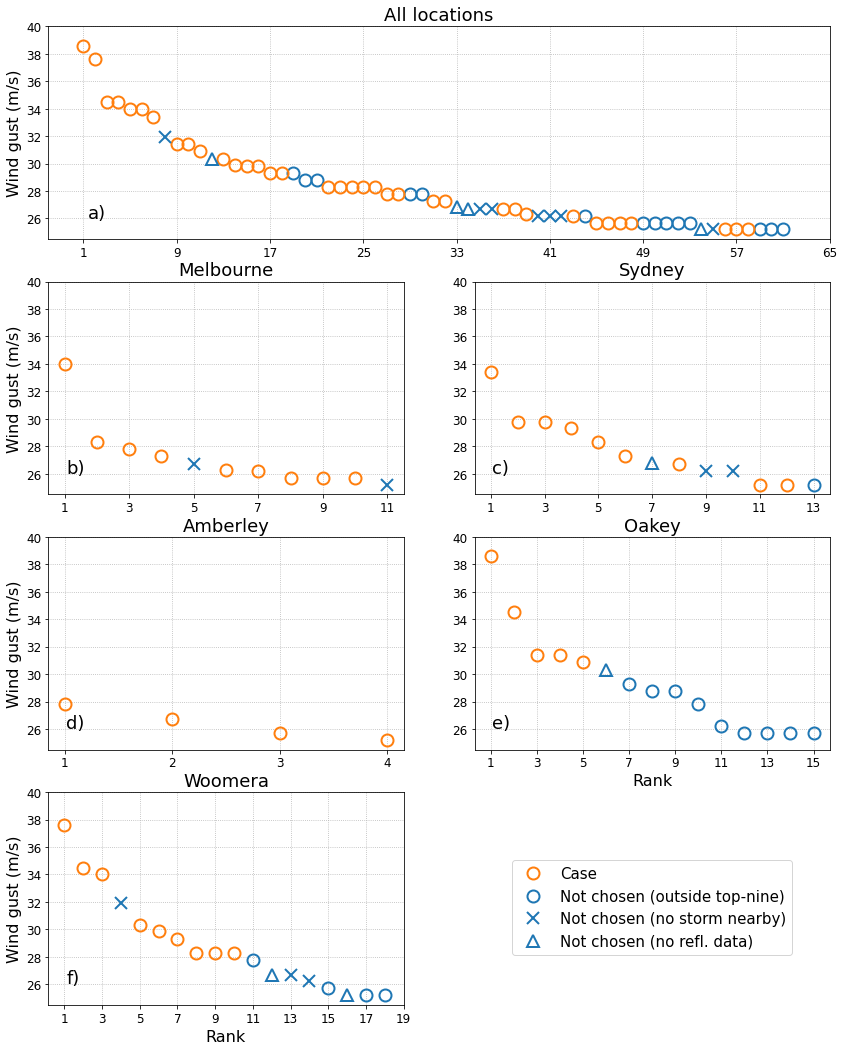

In [9]:
#Do some plotting. For the purposes of marker styles, flag Amberley events with case=2.

pot_cases.loc[(pot_cases.case==2) & (pot_cases.stn_name=="Amberley"),"case"] = 1

plt.figure(figsize=[14,18])
cnt=0

markers={0:"o",1:"o",2:"^",3:"x",4:"^"}
palette={0:"tab:blue",1:"tab:orange",2:"tab:orange",3:"tab:blue",4:"tab:blue"}
facecolors={0:"none",1:"none",2:"none",3:"tab:blue",4:"none"}
s=[12,12,12,12,12,12]
locs=[(0,0),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1)]

titles = ["All locations","Melbourne","Sydney","Amberley","Oakey","Woomera"]
letter = ["a","b","c","d","e","f"]
for location in [["Melbourne","Sydney","Amberley","Oakey","Woomera"],["Melbourne"],["Sydney"],["Amberley"],["Oakey"],["Woomera"]]:
    
    #ax=plt.subplot(2,3,cnt+1)
    if cnt==0:
        ax=plt.subplot2grid((4,2),locs[cnt],colspan=2)
    else:
        ax=plt.subplot2grid((4,2),locs[cnt])
    temp = pot_cases[np.in1d(pot_cases.stn_name,location)].sort_values(["wind_gust","case"])
    temp["order"] = np.arange(temp.shape[0],0,-1)

    for c in temp.case.unique():
        ax.plot(temp[temp.case==c].order, temp.wind_gust[temp.case==c], marker=markers[c], color=palette[c],
                  mfc=facecolors[c], mew=2, ms=s[cnt], linestyle="none")

    ax.grid(linestyle=":")
    ax.set_ylim([24.5,40])
    if letter[cnt]=="a":
        ax.set_xticks(np.arange(1,temp.shape[0]+8,8))
    elif letter[cnt]=="d":
        ax.set_xticks(np.arange(1,temp.shape[0]+1,1))
    else:
        ax.set_xticks(np.arange(1,temp.shape[0]+2,2))
        
    if cnt in [4,5]:
        ax.set_xlabel("Rank", size=16)
    if cnt in [0,1,3,5]:
        ax.set_ylabel("Wind gust (m/s)", size=16)
    ax.tick_params("both",labelsize=12)
    ax.set_title(titles[cnt],size=18)
    ax.text(0.05,0.1,letter[cnt]+")",size=18,transform=ax.transAxes)
    
    if cnt in [4]:
        custom = [Line2D([], [], marker='o', color='tab:orange', linestyle='None', mfc="none", ms=s[cnt], mew=2),
                    Line2D([], [], marker='o', color='tab:blue', linestyle='None', mfc="none", ms=s[cnt], mew=2),
                    Line2D([], [], marker='x', color='tab:blue', linestyle='None', mfc="tab:blue", ms=s[cnt], mew=2),
                     Line2D([], [], marker='^', color='tab:blue', linestyle='None', mfc="none", ms=s[cnt], mew=2)]
        plt.legend(custom, ['Case', 'Not chosen (outside top-nine)',
                           'Not chosen (no storm nearby)','Not chosen (no refl. data)'], loc='lower center', fontsize=15,
                  bbox_to_anchor=[0.5,-1],ncol=1)
    # else:
    #     custom = [Line2D([], [], marker='o', color='tab:orange', linestyle='None', mfc="none", ms=s, mew=2),
    #                 Line2D([], [], marker='^', color='tab:orange', linestyle='None', mfc="none", ms=s, mew=2),
    #                 Line2D([], [], marker='o', color='tab:blue', linestyle='None', mfc="none", ms=s, mew=2),
    #                 Line2D([], [], marker='x', color='tab:blue', linestyle='None', mfc="tab:blue", ms=s, mew=2),
    #                 Line2D([], [], marker='^', color='tab:blue', linestyle='None', mfc="none", ms=s, mew=2)]
    #     plt.legend(custom, ['Case (Oakey)', 'Case (Amberley)', 
    #                         'Not chosen (outside\ntop-nine, Oakey)',
    #                         'Not chosen (no storm\nnearby, Oakey)',
    #                         'Not chosen (no\nrefl. data, Oakey)',], loc='upper right', fontsize=12)        
    
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/rank_gust_distribution.jpeg",dpi=400,bbox_inches="tight")

In [6]:
pot_cases.stn_name.value_counts()

Woomera      18
Oakey        15
Sydney       13
Melbourne    11
Amberley      4
Name: stn_name, dtype: int64